In [1]:
import pandas as pd
## importing necessary librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("phone_usage_india.csv")

In [3]:
train_data.rename(columns={"Data Usage (GB/month)":"data_usage(gb/mo)","Calls Duration (mins/day)":"calls_dur(min/d)",
                           "Number of Apps Installed":"installed_apps","Social Media Time (hrs/day)":"soical_media(h/d)",
                           "E-commerce Spend (INR/month)":"E-commerce(INR/m)","Streaming Time (hrs/day)":"streaming(hrs/d)",
                           "Screen Time (hrs/day)":"Scr_time(h/d)","Gaming Time (hrs/day)":"gaming(hrs/d)",
                           "Monthly Recharge Cost (INR)":"recharge(INR)", "Primary Use":"Primary_Use"}, inplace=True)

In [4]:
train_data.drop(columns=["User ID"], axis=1, inplace=True)

In [5]:
# Function to correct OS
def fix_os(brand):
    return "iOS" if brand == "Apple" else "Android"

# Apply function to create a clean OS column
train_data["OS"] = train_data["Phone Brand"].apply(fix_os)

In [6]:
train_data.drop_duplicates(inplace=True)

In [7]:
train_data.dropna(inplace=True)

In [8]:
train_data.columns

Index(['Age', 'Gender', 'Location', 'Phone Brand', 'OS', 'Scr_time(h/d)',
       'data_usage(gb/mo)', 'calls_dur(min/d)', 'installed_apps',
       'soical_media(h/d)', 'E-commerce(INR/m)', 'streaming(hrs/d)',
       'gaming(hrs/d)', 'recharge(INR)', 'Primary_Use'],
      dtype='object')

In [9]:
# Define numerical columns to check for outliers
num_cols = ['Scr_time(h/d)', 'data_usage(gb/mo)', 'calls_dur(min/d)', 'installed_apps',
            'soical_media(h/d)', 'E-commerce(INR/m)', 'streaming(hrs/d)', 'gaming(hrs/d)', 'recharge(INR)']

# Function to remove outliers using IQR
def remove_outliers_iqr(train_data, cols):
    for col in cols:
        Q1 = train_data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = train_data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound
        
        # Remove outliers
        train_data = train_data[(train_data[col] >= lower_bound) & (train_data[col] <= upper_bound)]
    
    return train_data

train_data = remove_outliers_iqr(train_data, num_cols)

In [10]:
train_data.columns

Index(['Age', 'Gender', 'Location', 'Phone Brand', 'OS', 'Scr_time(h/d)',
       'data_usage(gb/mo)', 'calls_dur(min/d)', 'installed_apps',
       'soical_media(h/d)', 'E-commerce(INR/m)', 'streaming(hrs/d)',
       'gaming(hrs/d)', 'recharge(INR)', 'Primary_Use'],
      dtype='object')

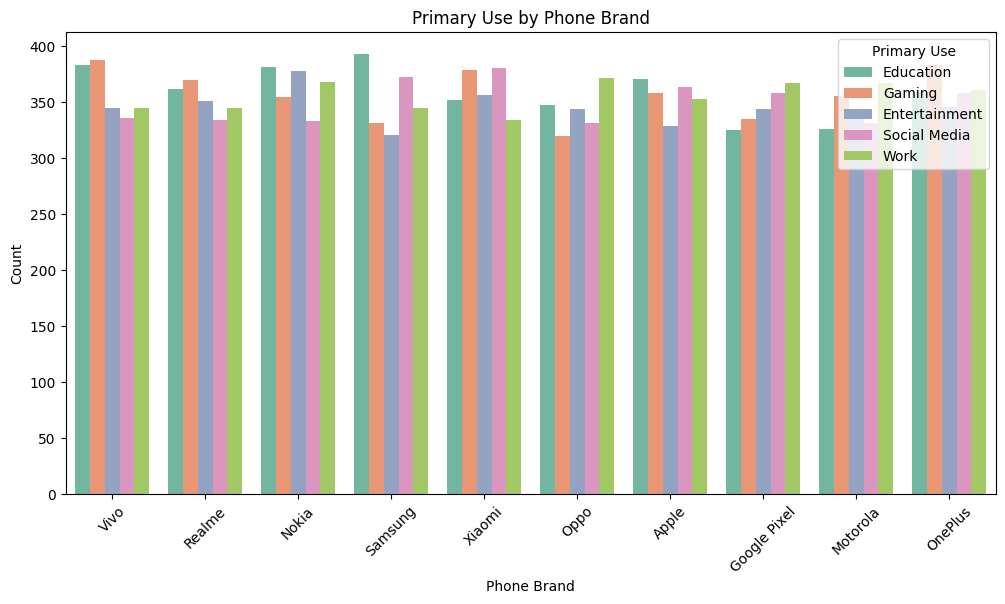

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot: Primary Use vs Phone Brand
plt.figure(figsize=(12, 6))
sns.countplot(x=train_data["Phone Brand"], hue=train_data["Primary_Use"], palette="Set2")
plt.xlabel("Phone Brand")
plt.ylabel("Count")
plt.title("Primary Use by Phone Brand")
plt.xticks(rotation=45)
plt.legend(title="Primary Use")
plt.show()

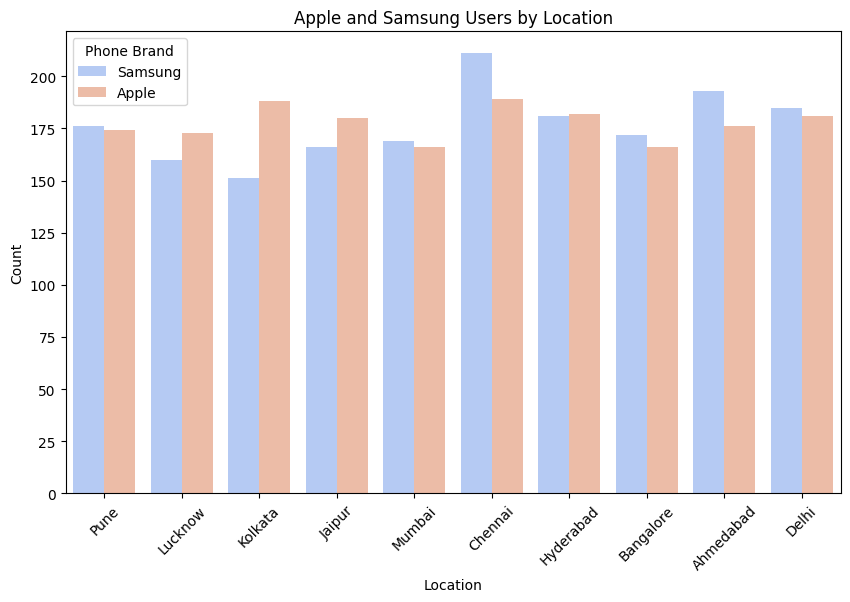

In [12]:
apple_samsung_df = train_data[train_data["Phone Brand"].isin(["Apple", "Samsung"])]
plt.figure(figsize=(10, 6))
sns.countplot(x=apple_samsung_df["Location"], hue=apple_samsung_df["Phone Brand"], palette="coolwarm")
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Apple and Samsung Users by Location")
plt.xticks(rotation=45)
plt.legend(title="Phone Brand")
plt.show()

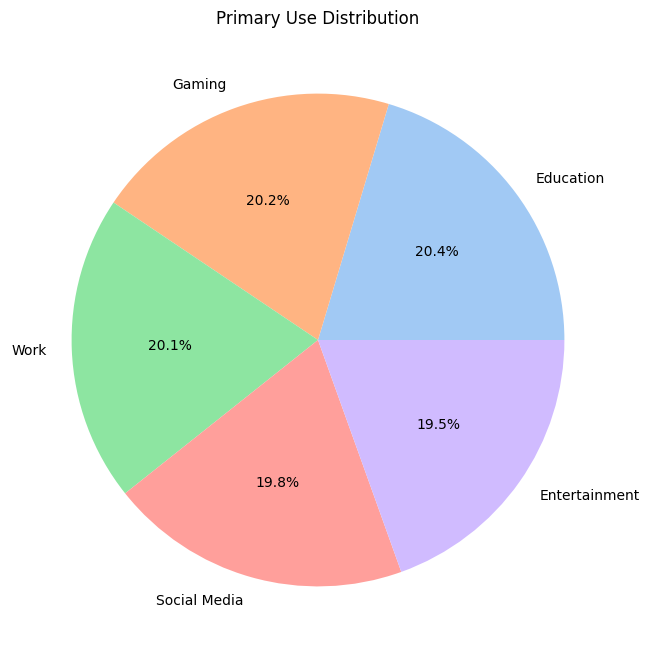

In [16]:
phone_brand_counts = train_data["Primary_Use"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(phone_brand_counts, labels=phone_brand_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Primary Use Distribution")
plt.show()


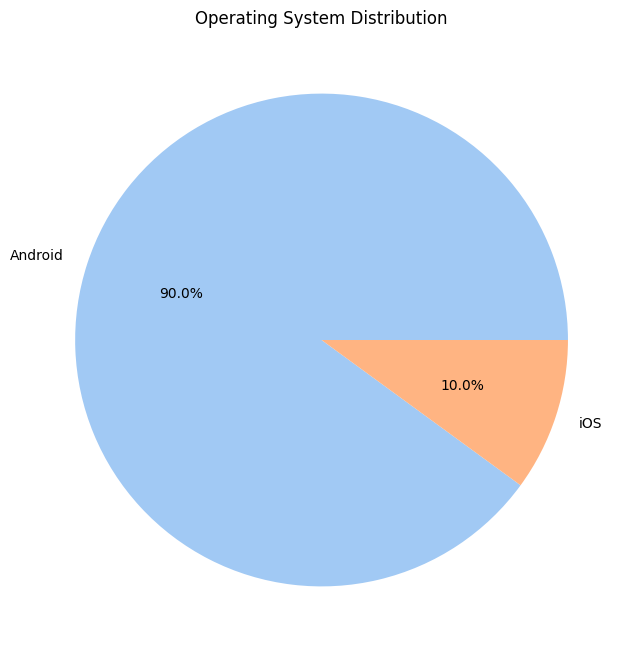

In [17]:
phone_brand_counts = train_data["OS"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(phone_brand_counts, labels=phone_brand_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Operating System Distribution")
plt.show()

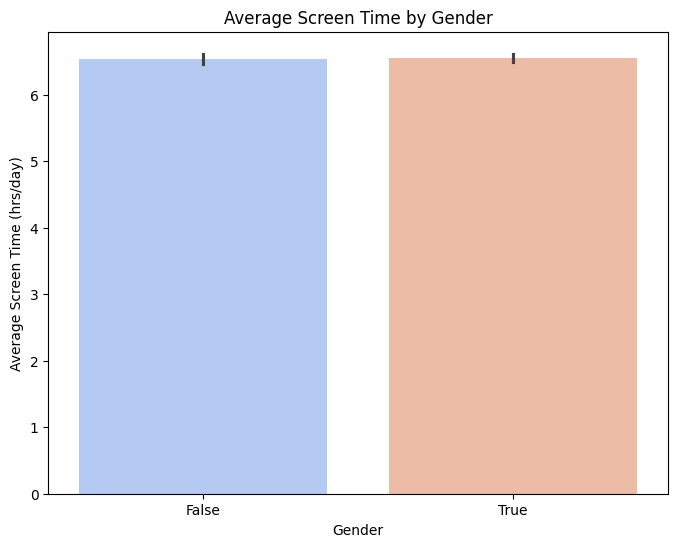

In [18]:
# Bar plot: Average Screen Time by Gender
plt.figure(figsize=(8, 6))
sns.barplot(x=train_data["Gender"].isin(["Male", "Female"]), y=train_data["Scr_time(h/d)"], palette="coolwarm")
plt.xlabel("Gender")
plt.ylabel("Average Screen Time (hrs/day)")
plt.title("Average Screen Time by Gender")
plt.show()


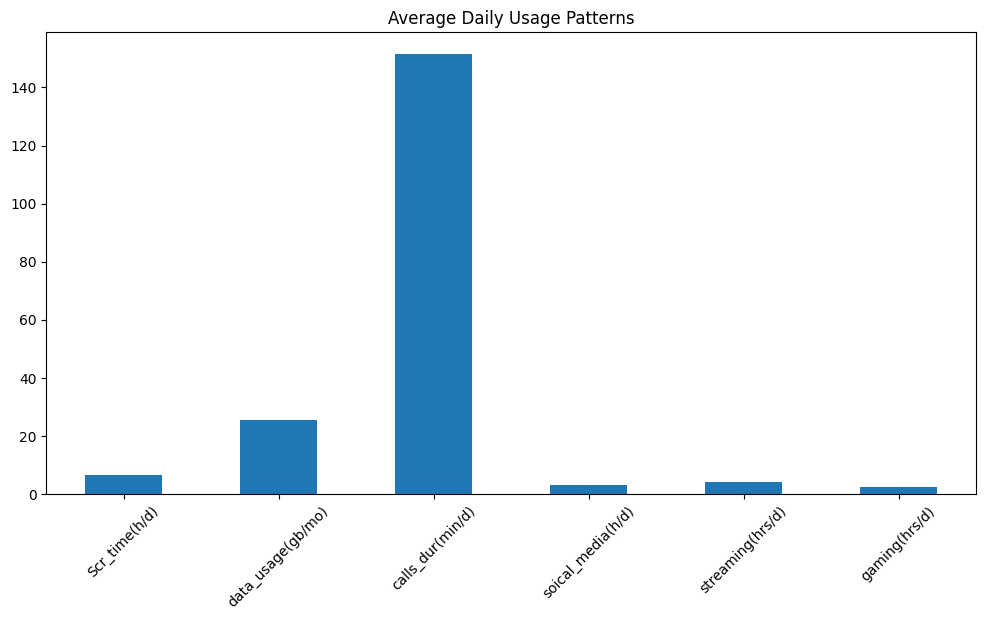

In [ ]:
# Average Usage Patterns
usage_cols = ['Scr_time(h/d)','data_usage(gb/mo)', 'calls_dur(min/d)','soical_media(h/d)', 'streaming(hrs/d)','gaming(hrs/d)']
plt.figure(figsize=(12, 6))
train_data[usage_cols].mean().plot(kind='bar')
plt.title('Average Daily Usage Patterns')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['Gender', 'Location', 'Phone Brand', 'OS', 'Primary_Use']

for col in categorical_cols:
    train_data[col] = le.fit_transform(train_data[col])

In [21]:
train_data.head(15)

,Age,Gender,Location,Phone Brand,OS,Scr_time(h/d),data_usage(gb/mo),calls_dur(min/d),installed_apps,soical_media(h/d),E-commerce(INR/m),streaming(hrs/d),gaming(hrs/d),recharge(INR),Primary_Use
0,53,1,8,8,0,3.7,23.9,37.9,104,3.9,469,5.2,4.1,803,0
1,60,2,3,6,0,9.2,28.1,13.7,169,2.8,4997,5.1,0.4,1526,2
2,37,0,0,3,0,4.5,12.3,66.8,96,3.0,2381,1.7,2.9,1619,1
3,32,1,9,7,0,11.0,25.6,156.2,146,5.2,1185,3.2,0.3,1560,1
4,16,1,8,9,0,2.2,2.5,236.2,86,5.5,106,3.4,2.3,742,3
5,21,1,5,5,0,5.4,10.6,210.6,25,4.2,6285,0.6,4.8,1749,1
6,57,0,7,0,1,6.0,35.2,154.5,123,0.8,2653,2.9,2.3,1073,3
7,56,2,6,6,0,3.1,43.5,125.3,188,2.3,9767,5.2,5.0,1136,1
8,46,0,6,5,0,5.3,46.4,21.3,194,3.7,2870,6.1,2.8,1253,1
9,44,2,6,0,1,9.9,10.6,180.2,84,4.8,9193,7.6,0.4,168,0


In [22]:
feature_cols = ['Age', 'Gender','OS', 'Scr_time(h/d)',
       'data_usage(gb/mo)', 'calls_dur(min/d)', 'installed_apps',
       'soical_media(h/d)', 'E-commerce(INR/m)', 'streaming(hrs/d)',
       'gaming(hrs/d)', 'recharge(INR)']

In [23]:
train_data['Primary_Use'] = train_data['Primary_Use'].astype(str)  # Convert to string 

In [24]:
X = train_data[feature_cols]
y = train_data['Primary_Use']

In [25]:
y = y.astype(int)

In [26]:
 # Scale the features
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the features
X_scaled = scaler.fit_transform(X)

# Print mean and standard deviation of features
print("Feature Means:\n", scaler.mean_)
print("\nFeature Std Devs:\n", scaler.scale_)

Feature Means:
 [3.75842474e+01 9.95646274e-01 1.00361868e-01 6.54637566e+00
 2.54112575e+01 1.51405846e+02 1.04584869e+02 3.25236911e+00
 5.07570785e+03 4.25061631e+00 2.49087414e+00 1.04278537e+03]

Feature Std Devs:
 [1.33378747e+01 8.18916657e-01 3.00481886e-01 3.17258754e+00
 1.41217682e+01 8.49209524e+01 5.52155359e+01 1.59017813e+00
 2.87152366e+03 2.15562229e+00 1.44596220e+00 5.52486447e+02]


Evaluating Classification Models...

Evaluating Logistic Regression...

Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.18      0.23      0.21       721
           1       0.19      0.18      0.19       690
           2       0.19      0.20      0.19       715
           3       0.18      0.10      0.13       700
           4       0.19      0.22      0.20       712

    accuracy                           0.19      3538
   macro avg       0.19      0.19      0.18      3538
weighted avg       0.19      0.19      0.18      3538


Evaluating Decision Tree...

Detailed Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.24      0.09      0.13       721
           1       0.20      0.27      0.23       690
           2       0.22      0.17      0.19       715
           3       0.20      0.33      0.25       700
           4       0.19      0.1

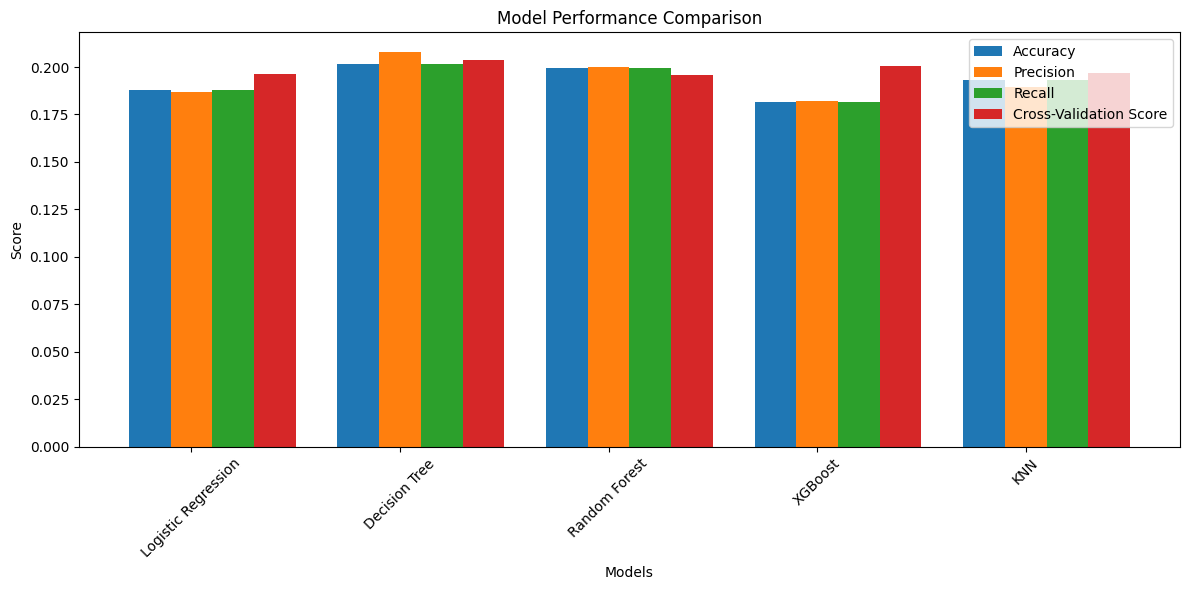


Model Performance Summary:
              Model  Accuracy  Precision   Recall  Cross-Validation Score
Logistic Regression  0.187677   0.186868 0.187677                0.196313
      Decision Tree  0.201526   0.207880 0.201526                0.203890
      Random Forest  0.199548   0.200091 0.199548                0.196030
            XGBoost  0.181741   0.182085 0.181741                0.200498
                KNN  0.193330   0.189329 0.193330                0.197105

🏆 The best model is: Decision Tree (Saved as decision_tree_model.pkl)


In [55]:
from sklearn.model_selection import train_test_split, cross_val_score


def evaluate_classification_models(X, y):
    # Stratify to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)  # Replacing SVM with KNN
    }

    trained_models = {}  # Store trained models
    results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])

    # Evaluate each model
    for name, model in models.items():
        print(f"\nEvaluating {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        # Perform cross-validation
        cv_scores = cross_val_score(model, X, y, cv=3)  # Reduce CV folds for speed
        avg_cv_score = np.mean(cv_scores)

        # Store trained model
        trained_models[name] = model

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            'Model': [name],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'Cross-Validation Score': [avg_cv_score]
        })], ignore_index=True)

        # Print classification report
        print(f"\nDetailed Classification Report for {name}:")
        print(classification_report(y_test, y_pred))

    # Identify the best model based on cross-validation score
    best_model_name = results_df.loc[results_df['Cross-Validation Score'].idxmax(), 'Model']
    best_model = trained_models[best_model_name]

    # Save the best model
    best_model_filename = f"{best_model_name.lower().replace(' ', '_')}_model.pkl"
    with open(best_model_filename, "wb") as model_file:
        pickle.dump(best_model, model_file)

    print(f"\n🏆 Best Model: {best_model_name} (Saved as {best_model_filename})")

    # Plot model performance
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'Cross-Validation Score']
    
    x = np.arange(len(models))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, results_df[metric], width, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width, results_df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # # Heatmap of results
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(results_df.set_index('Model')[metrics], annot=True, cmap='Blues', fmt='.3f')
    # plt.title('Model Performance Metrics Heatmap')
    # plt.tight_layout()
    # plt.show()

    return results_df, best_model_name, best_model_filename
    
print("Evaluating Classification Models...")
results_df, best_model_name, best_model_filename = evaluate_classification_models(X_scaled, y)

# Print final results
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))

# Print best model
print(f"\n🏆 The best model is: {best_model_name} (Saved as {best_model_filename})")

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

# Define hyperparameters to tune
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4, 6]  
}

# Initialize Decision Tree
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)

# Grid search for best parameters
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
print(f"Best Decision Tree Parameters: {grid_search.best_params_}")

# Train the best Decision Tree
best_dt.fit(X_train, y_train)

# Save the improved model
import pickle
with open("decision_tree_model.pkl", "wb") as model_file:
    pickle.dump(best_dt, model_file)

print("✅ Improved Decision Tree model saved as decision_tree_model.pkl")

Best Decision Tree Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
✅ Improved Decision Tree model saved as decision_tree_model.pkl


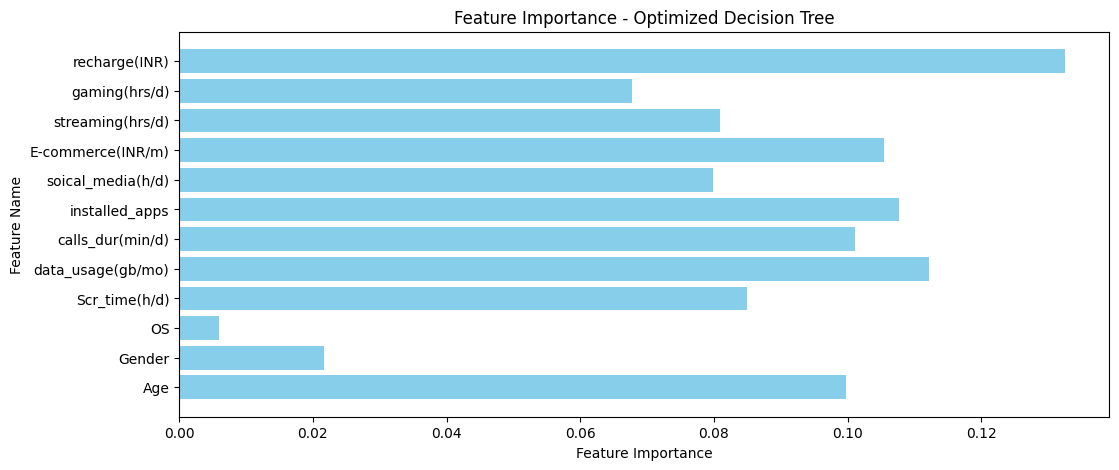

In [58]:
import matplotlib.pyplot as plt

# Get feature importance from the best Decision Tree model
feature_importance = best_dt.feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 5))
plt.barh(feature_cols, feature_importance, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance - Optimized Decision Tree")
plt.show()

In [59]:
# Remove low-importance features (OS, Gender)
important_features = ['Age','Scr_time(h/d)',
       'data_usage(gb/mo)', 'calls_dur(min/d)', 'installed_apps',
       'soical_media(h/d)', 'E-commerce(INR/m)', 'streaming(hrs/d)',
       'gaming(hrs/d)', 'recharge(INR)']

# Update X dataset
X_filtered = train_data[important_features]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# Train Decision Tree Again
dt = DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=1, random_state=42)
dt.fit(X_train, y_train)

# Save the updated model
with open("decision_tree_model.pkl", "wb") as model_file:
    pickle.dump(dt, model_file)

print("✅ Retrained Decision Tree model saved as decision_tree_model.pkl")

✅ Retrained Decision Tree model saved as decision_tree_model.pkl


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}
# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# Train models with GridSearchCV
best_models = {}
for model_name, param_grid in param_grids.items():
    model = models[model_name]  # Fetch the model from your dictionary
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)  # Train with training data
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"✅ Best {model_name} Parameters: {grid_search.best_params_}")

✅ Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
✅ Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
✅ Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
✅ Best KNN Parameters: {'n_neighbors': 3, 'weights': 'uniform'}


In [62]:
from sklearn.metrics import accuracy_score

# Store models with best hyperparameters
best_models = {
    "Random Forest": RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3, weights='uniform')
}

model_scores = {}

for model_name, model in best_models.items():
    model.fit(X_train, y_train)  # Train each model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[model_name] = accuracy
    print(f"🎯 {model_name} Accuracy: {accuracy:.4f}")

# Find the best model
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n🏆 The Best Model is: {best_model_name} with Accuracy: {model_scores[best_model_name]:.4f}")

🎯 Random Forest Accuracy: 0.1939
🎯 XGBoost Accuracy: 0.1998
🎯 Gradient Boosting Accuracy: 0.1953
🎯 KNN Accuracy: 0.2066

🏆 The Best Model is: KNN with Accuracy: 0.2066


In [61]:
import pickle

# Train the best KNN model on the full dataset
best_model = KNeighborsClassifier(n_neighbors=3, weights='uniform')
best_model.fit(X_train, y_train)

# Save the model
model_filename = "knn_model.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Best Model (KNN) Saved as {model_filename}")

✅ Best Model (KNN) Saved as knn_model.pkl


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm

Performing K-means Analysis...


Analyzing K-means: 100%|██████████| 5/5 [01:17<00:00, 15.41s/it]


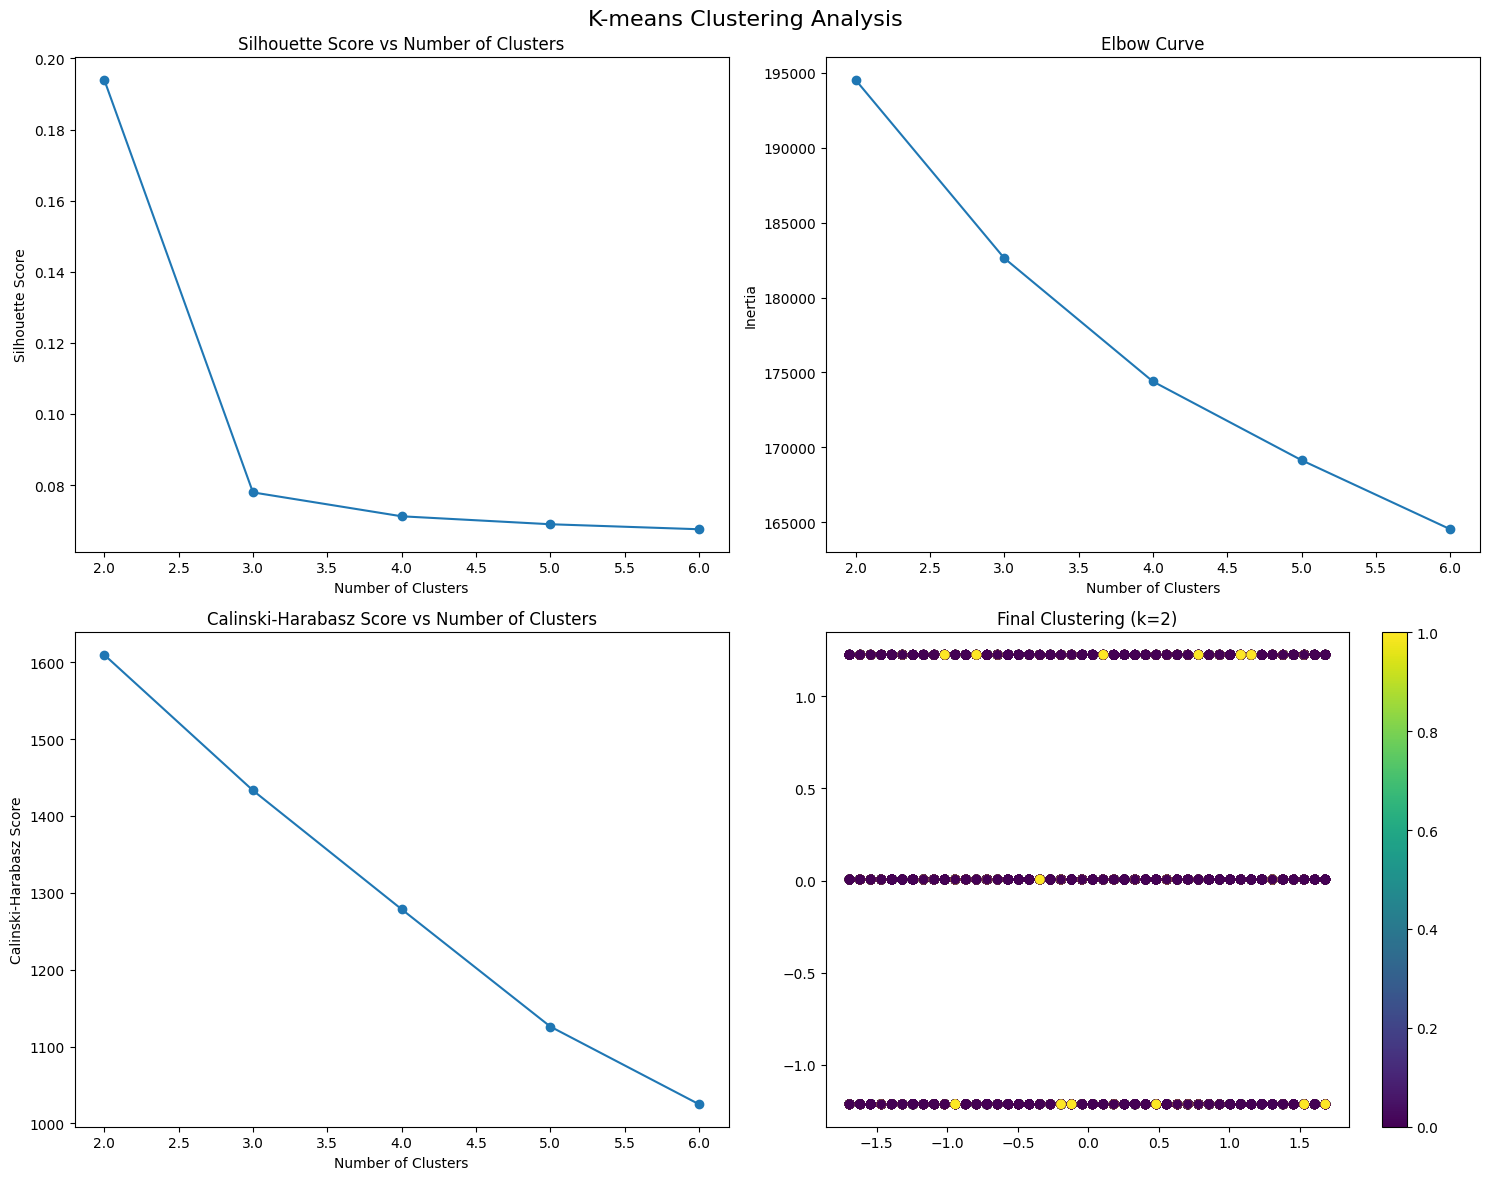

In [65]:
# K-means Detailed Analysis
def analyze_kmeans(X, n_clusters_range=range(2, 7)):
    """
    Detailed K-means clustering analysis with multiple metrics
    """
    print("Performing K-means Analysis...")
    results = {
        'silhouette_scores': [],
        'inertia_scores': [],
        'calinski_scores': []
    }
    
    # Calculate metrics for different cluster numbers
    for n_clusters in tqdm(n_clusters_range, desc="Analyzing K-means"):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        results['silhouette_scores'].append(silhouette_score(X, labels))
        results['inertia_scores'].append(kmeans.inertia_)
        results['calinski_scores'].append(calinski_harabasz_score(X, labels))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('K-means Clustering Analysis', fontsize=16)
    
    # Plot 1: Silhouette scores
    axes[0, 0].plot(list(n_clusters_range), results['silhouette_scores'], marker='o')
    axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    
    # Plot 2: Elbow curve
    axes[0, 1].plot(list(n_clusters_range), results['inertia_scores'], marker='o')
    axes[0, 1].set_title('Elbow Curve')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Inertia')
    
    # Plot 3: Calinski-Harabasz scores
    axes[1, 0].plot(list(n_clusters_range), results['calinski_scores'], marker='o')
    axes[1, 0].set_title('Calinski-Harabasz Score vs Number of Clusters')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    
    # Find optimal number of clusters
    optimal_clusters = n_clusters_range[np.argmax(results['silhouette_scores'])]
    
    # Final clustering with optimal number
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Plot 4: Final clustering result
    scatter = axes[1, 1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    axes[1, 1].set_title(f'Final Clustering (k={optimal_clusters})')
    plt.colorbar(scatter, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return labels, optimal_clusters, kmeans.cluster_centers_
kmeans_labels, optimal_k, centers = analyze_kmeans(X_scaled)

Performing Hierarchical Clustering Analysis...


Analyzing Hierarchical: 100%|██████████| 5/5 [02:19<00:00, 27.87s/it]


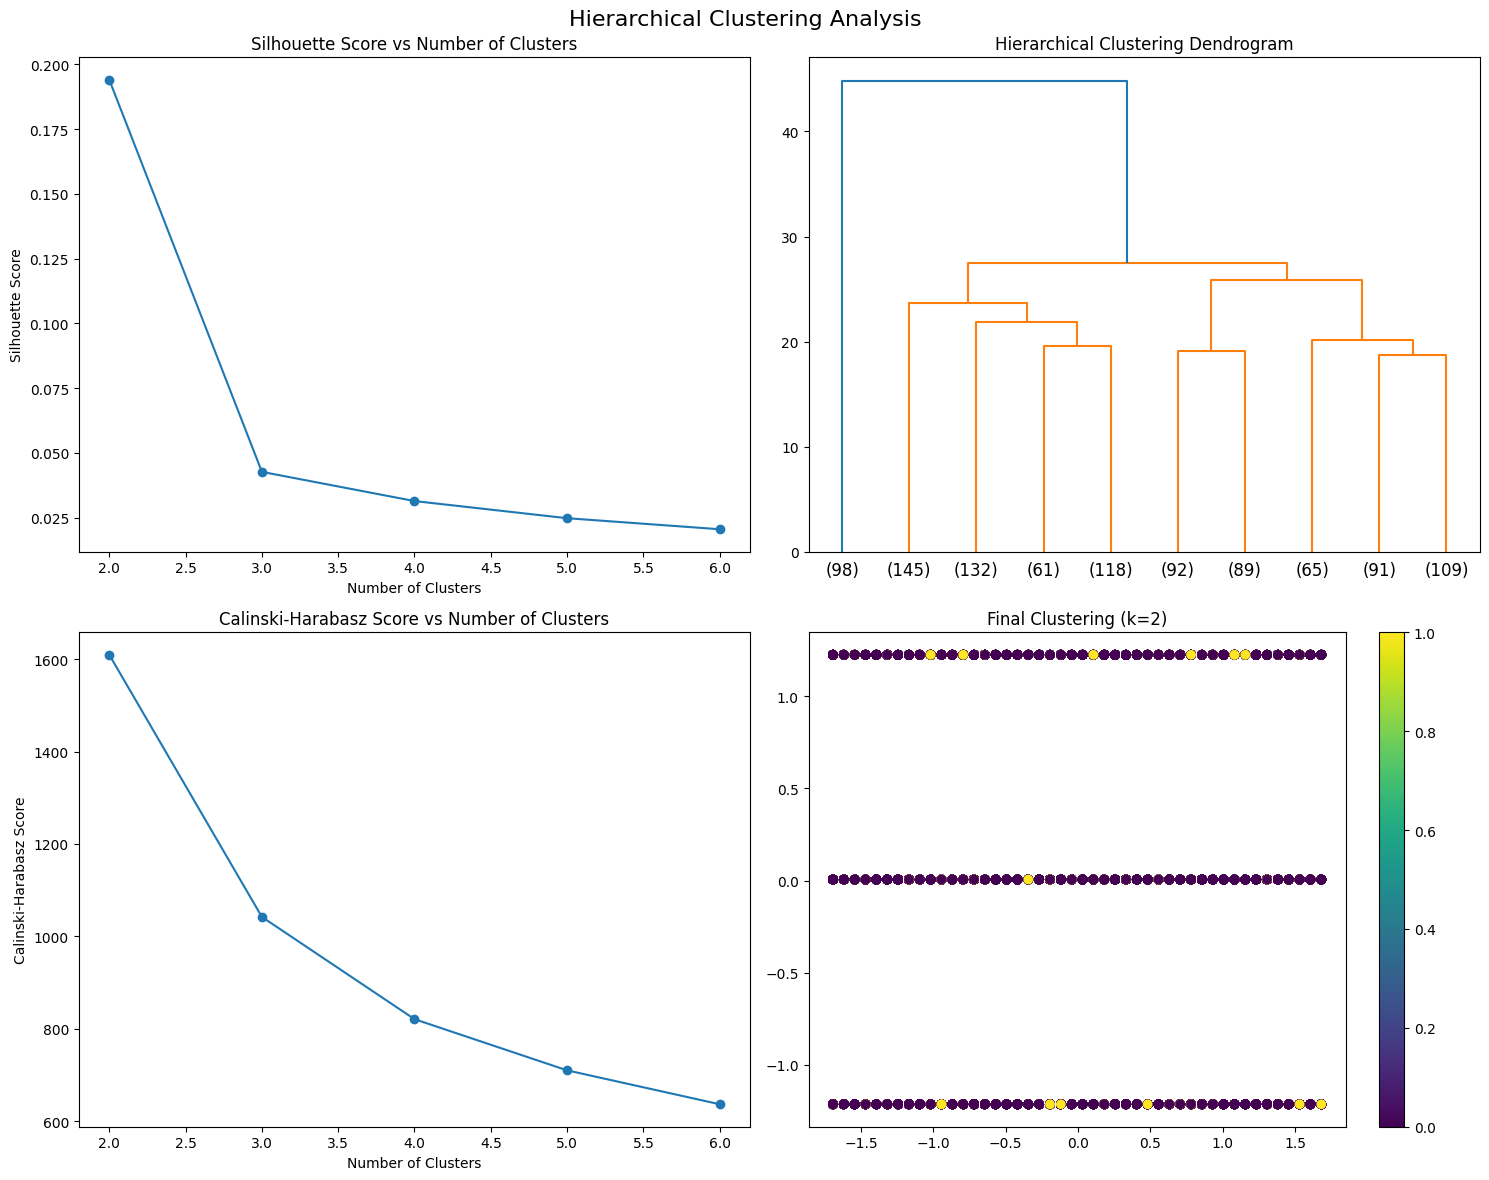

In [66]:
def analyze_hierarchical(X, n_clusters_range=range(2, 7)):
    """
    Detailed hierarchical clustering analysis
    """
    print("Performing Hierarchical Clustering Analysis...")
    results = {
        'silhouette_scores': [],
        'calinski_scores': []
    }
    
    # Calculate metrics for different cluster numbers
    for n_clusters in tqdm(n_clusters_range, desc="Analyzing Hierarchical"):
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        labels = hierarchical.fit_predict(X)
        
        results['silhouette_scores'].append(silhouette_score(X, labels))
        results['calinski_scores'].append(calinski_harabasz_score(X, labels))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Hierarchical Clustering Analysis', fontsize=16)
    
    # Plot 1: Silhouette scores
    axes[0, 0].plot(list(n_clusters_range), results['silhouette_scores'], marker='o')
    axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    
    # Plot 2: Dendrogram
    if X.shape[0] > 1000:
        indices = np.random.choice(X.shape[0], 1000, replace=False)
        X_sample = X[indices]
        linkage_matrix = linkage(X_sample, method='ward')
    else:
        linkage_matrix = linkage(X, method='ward')
    
    dendrogram(linkage_matrix, ax=axes[0, 1], truncate_mode='lastp', p=10)
    axes[0, 1].set_title('Hierarchical Clustering Dendrogram')
    
    # Plot 3: Calinski-Harabasz scores
    axes[1, 0].plot(list(n_clusters_range), results['calinski_scores'], marker='o')
    axes[1, 0].set_title('Calinski-Harabasz Score vs Number of Clusters')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    
    # Find optimal number of clusters
    optimal_clusters = n_clusters_range[np.argmax(results['silhouette_scores'])]
    
    # Final clustering with optimal number
    hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters)
    labels = hierarchical.fit_predict(X)
    
    # Plot 4: Final clustering result
    scatter = axes[1, 1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    axes[1, 1].set_title(f'Final Clustering (k={optimal_clusters})')
    plt.colorbar(scatter, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return labels, optimal_clusters
hierarchical_labels, optimal_h = analyze_hierarchical(X_scaled)


Performing DBSCAN Analysis...


Analyzing DBSCAN: 100%|██████████| 10/10 [05:21<00:00, 32.11s/it]


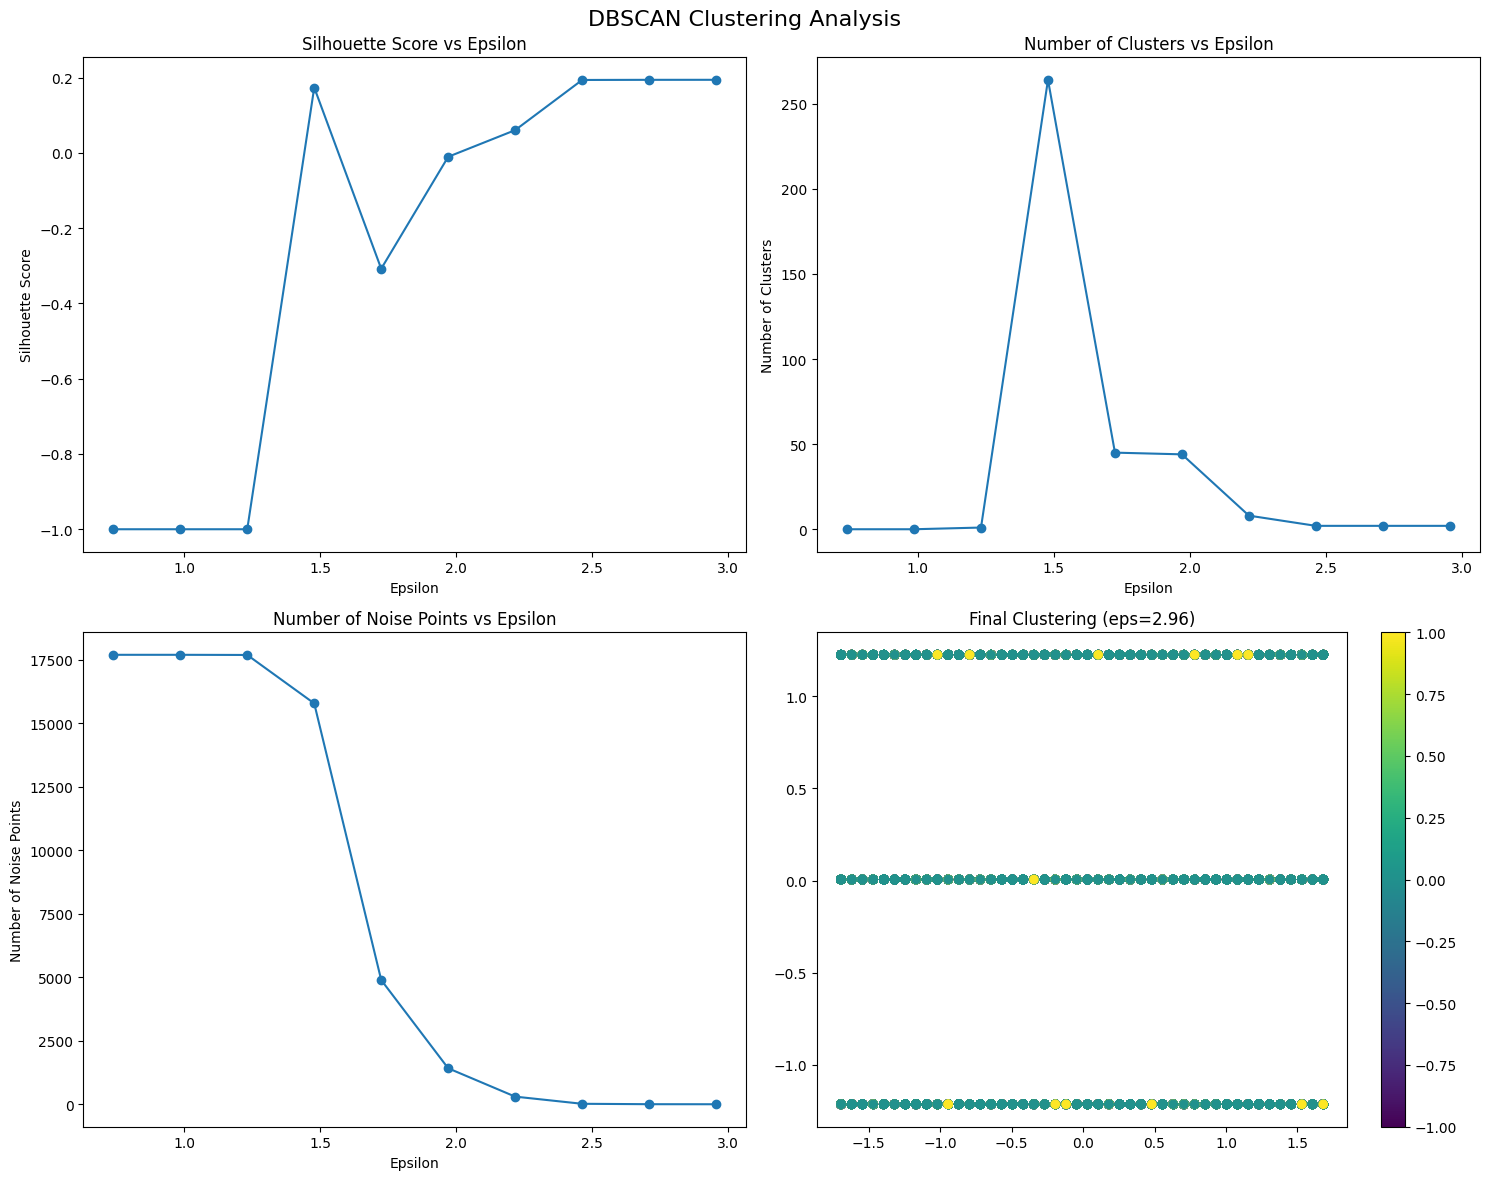

In [67]:
def analyze_dbscan(X):
    """
    Detailed DBSCAN clustering analysis
    """
    print("Performing DBSCAN Analysis...")
    
    
   # Determine eps range dynamically based on data
    from sklearn.neighbors import NearestNeighbors
    neighb = NearestNeighbors(n_neighbors=2)
    neighb.fit(X)
    distances, _ = neighb.kneighbors(X)
    mean_dist = np.mean(distances[:, 1])
    eps_range = np.linspace(mean_dist/2, mean_dist*2, 10)
    
    results = {
        'eps_values': eps_range,
        'silhouette_scores': [],
        'n_clusters': [],
        'n_noise': []
    }
    
    for eps in tqdm(eps_range, desc="Analyzing DBSCAN"):
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Only calculate silhouette score if there are at least 2 clusters
        # and not all points are noise
        if n_clusters >= 2 and n_noise < len(X):
            # Filter out noise points for silhouette calculation
            valid_points = labels != -1
            if np.sum(valid_points) > 1:
                sil_score = silhouette_score(X[valid_points], labels[valid_points])
            else:
                sil_score = -1
        else:
            sil_score = -1
            
        results['silhouette_scores'].append(sil_score)
        results['n_clusters'].append(n_clusters)
        results['n_noise'].append(n_noise)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('DBSCAN Clustering Analysis', fontsize=16)
    
    # Plot 1: Silhouette scores
    axes[0, 0].plot(eps_range, results['silhouette_scores'], marker='o')
    axes[0, 0].set_title('Silhouette Score vs Epsilon')
    axes[0, 0].set_xlabel('Epsilon')
    axes[0, 0].set_ylabel('Silhouette Score')
    
    # Plot 2: Number of clusters
    axes[0, 1].plot(eps_range, results['n_clusters'], marker='o')
    axes[0, 1].set_title('Number of Clusters vs Epsilon')
    axes[0, 1].set_xlabel('Epsilon')
    axes[0, 1].set_ylabel('Number of Clusters')
    
    # Plot 3: Number of noise points
    axes[1, 0].plot(eps_range, results['n_noise'], marker='o')
    axes[1, 0].set_title('Number of Noise Points vs Epsilon')
    axes[1, 0].set_xlabel('Epsilon')
    axes[1, 0].set_ylabel('Number of Noise Points')
    
    # Find optimal epsilon (handling the case where all scores are -1)
    valid_scores = np.array(results['silhouette_scores'])
    if np.all(valid_scores == -1):
        # If no good clusters found, choose eps that minimizes noise points
        optimal_eps = eps_range[np.argmin(results['n_noise'])]
    else:
        # Otherwise choose eps with best silhouette score
        optimal_eps = eps_range[np.argmax(valid_scores)]
    
    # Final clustering with optimal epsilon
    dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
    labels = dbscan.fit_predict(X)
    
    # Plot 4: Final clustering result
    scatter = axes[1, 1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    axes[1, 1].set_title(f'Final Clustering (eps={optimal_eps:.2f})')
    plt.colorbar(scatter, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return labels, optimal_eps
dbscan_labels, optimal_eps = analyze_dbscan(X_scaled)

In [68]:
# Store results
results = {
    'kmeans': kmeans_labels,
    'hierarchical': hierarchical_labels,
    'dbscan': dbscan_labels,
}

# Add labels to original dataframe
for method, labels in results.items():
    train_data[f'cluster_{method}'] = labels

# Save results
train_data.to_csv('clustering_results.csv', index=False)